surprise 모듈을 설치

In [ ]:
!pip install surprise

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 11.8 MB 4.2 MB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.1-cp37-cp37m-linux_x86_64.whl size=1633979 sha256=67d185bf4cddc2884d8258bccd59456847e6ad78f0fb980a91c92c91561998cf
  Stored in directory: /root/.cache/pip/wheels/76/44/74/b498c42be47b2406bd27994e16c5188e337c657025ab400c1c
Successfully built scikit-surprise


In [ ]:
!wget "https://grepp-reco-test.s3.ap-northeast-2.amazonaws.com/movielens/movies.csv"
!wget "https://grepp-reco-test.s3.ap-northeast-2.amazonaws.com/movielens/ratings.csv"

--2022-09-02 03:53:27--  https://grepp-reco-test.s3.ap-northeast-2.amazonaws.com/movielens/movies.csv
Resolving grepp-reco-test.s3.ap-northeast-2.amazonaws.com (grepp-reco-test.s3.ap-northeast-2.amazonaws.com)... 52.219.56.140
Connecting to grepp-reco-test.s3.ap-northeast-2.amazonaws.com (grepp-reco-test.s3.ap-northeast-2.amazonaws.com)|52.219.56.140|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 458390 (448K) [text/csv]
Saving to: ‘movies.csv’

movies.csv          100%[===================>] 447.65K   585KB/s    in 0.8s    

2022-09-02 03:53:28 (585 KB/s) - ‘movies.csv’ saved [458390/458390]

--2022-09-02 03:53:28--  https://grepp-reco-test.s3.ap-northeast-2.amazonaws.com/movielens/ratings.csv
Resolving grepp-reco-test.s3.ap-northeast-2.amazonaws.com (grepp-reco-test.s3.ap-northeast-2.amazonaws.com)... 52.219.56.140
Connecting to grepp-reco-test.s3.ap-northeast-2.amazonaws.com (grepp-reco-test.s3.ap-northeast-2.amazonaws.com)|52.219.56.140|:443... connected.


# 데이터 로딩


In [ ]:
import numpy as np
import pandas as pd

In [ ]:
movies = pd.read_csv("movies.csv")
ratings = pd.read_csv("ratings.csv")

In [ ]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [ ]:
ratings.head() 

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [ ]:
# ratings에 비어있는 셀들이 되게 많음 
itemRatings = ratings.pivot_table(index=['userId'],columns=['movieId'],values='rating')
itemRatings.head()

movieId,1,2,3,4,5,6,7,8,9,10,...,161084,161155,161594,161830,161918,161944,162376,162542,162672,163949
userId,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
movie_ratings = pd.merge(movies, ratings, left_on='movieId', right_on='movieId')

In [ ]:
movie_ratings.head()

,movieId,title,genres,userId,rating,timestamp
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,7,3.0,851866703
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,9,4.0,938629179
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,13,5.0,1331380058
3,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,15,2.0,997938310
4,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,19,3.0,855190091


In [ ]:
movies.shape

(9125, 3)

In [ ]:
ratings.shape

(100004, 4)

In [ ]:
movie_ratings.shape

(100004, 6)

In [ ]:
def getMovieName(movie_ratings, movieID):
    return movie_ratings[movie_ratings["movieId"] == movieID][["title", "genres"]].values[0]

def getMovieID(movie_ratings, movieName):
    return movie_ratings[movie_ratings["title"] == movieName][["movieId", "genres"]].values[0]

## 영화 데이터를 surprise 모듈을 통해 로딩

In [ ]:
from surprise import Dataset
from surprise import Reader
from collections import defaultdict

reader = Reader(line_format='user item rating timestamp', sep=',', skip_lines=1) # 포맷 지정해주기 (처음에는 user, 그 다음에는 item, 그 다음에는 rating, 마지막에는 timestamp 가 나온다.)
data = Dataset.load_from_file("ratings.csv", reader=reader)

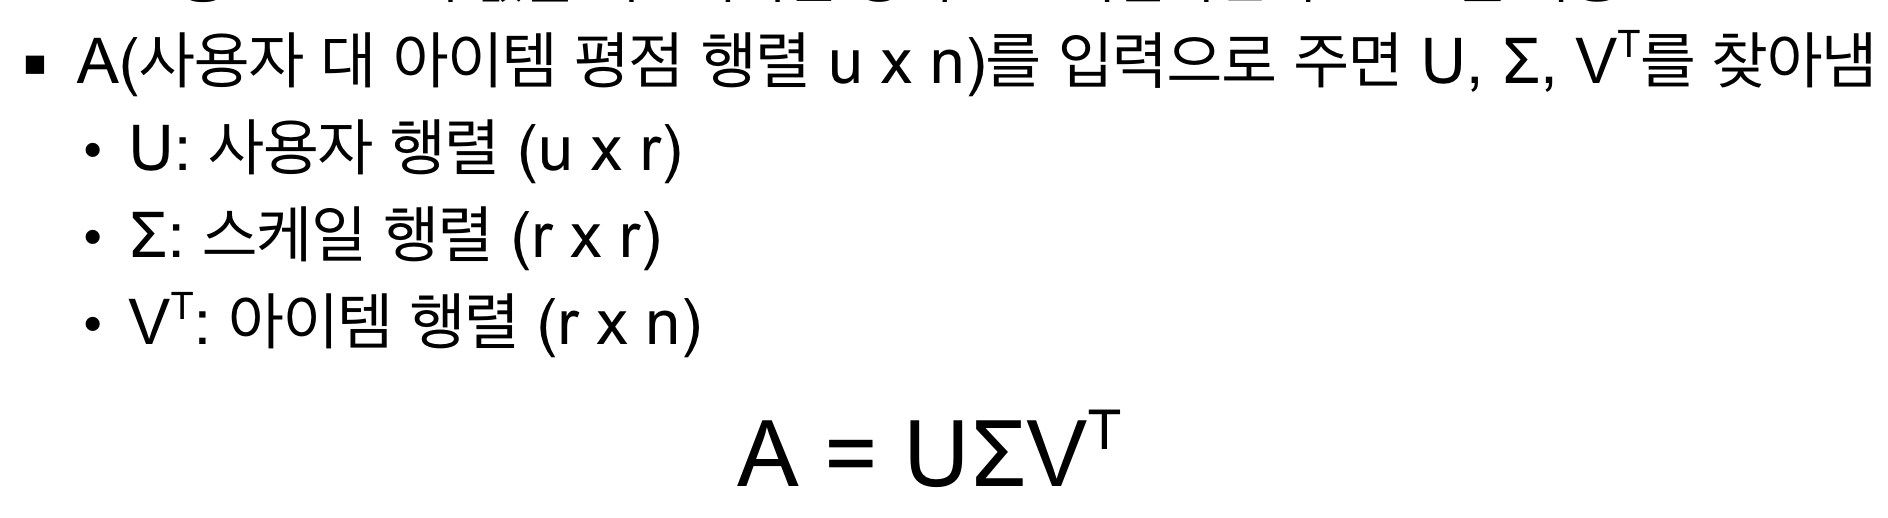

In [ ]:
from surprise import SVD
from surprise import NormalPredictor
from surprise.model_selection import GridSearchCV

# 하이퍼 파라미터 그리드 검색을 해서 최적의 파라미터를 찾는다
# scikit-learn의 GridSearchCV와 아주 흡사
# - n_factors: 축소 차원수 (앞 그림에서 시그마 행렬의 차원수 - r)
# - n_epochs: 전체 데이터 셋을 훈련시키는 횟수
# - lr_all: 학습률 

param_grid = {
  'n_epochs': [20, 30],
  'lr_all': [0.005, 0.010], # 학습률(값이 적당해야 함. 학습률이 너무 크면 converge가 안 될 확률이 있고, 학습률이 너무 작으면 시간이 오래 걸릴 수 있음)           
  'n_factors': [50, 100] # 50개와 100개를 테스트
  # => 총 8개의 조합(2*2*2)
}

# 3-폴드 교차검증을 하고 두 개의 비용함수를 사용: RMSE와 MAE (Mean Absolute Error)
gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=3) # cv: cross validation(교차 검증) / 여기서는 3-폴드 교차검증 
gs.fit(data)

In [ ]:
# RMSE
print("Best RMSE score attained: ", gs.best_score['rmse']) # RMSE로 봤을 때 가장 score가 좋은 것(가장 작은 것)
print("Best RMSE params: ", gs.best_params['rmse']) # 가장 작은 score를 도출해준 하이퍼 파라미터들이 무엇이냐?
# 제일 잘 나온(가장 작은) score가 0.8979 정도 => (매우 중요) 예측한 평점과 실제 평점사이에는 0.9 정도의 차이가 난다 (큰 차이가 아님)
# 20번의 학습 / r = 50 일 때 최고의 성능

Best RMSE score attained:  0.8979470184610981
Best RMSE params:  {'n_epochs': 20, 'lr_all': 0.005, 'n_factors': 50}


In [ ]:
# MAE
print("Best RAE score attained: ", gs.best_score['mae']) # mae로 봤을 때 가장 score가 좋은 것(가장 작은 것)
print("Best RAE params: ", gs.best_params['mae']) # 가장 작은 score를 도출해준 하이퍼 파라미터들이 무엇이냐?
# 제일 잘 나온(가장 작은) score가 0.69 정도 => (매우 중요) 예측한 평점과 실제 평점사이에는 0.7 정도의 차이가 난다 (큰 차이가 아님)
# 20번의 학습 / r = 50 일 때 최고의 성능

# RMSE 와 MAE의 차이점: 
  # 1보다 작은 값을 제곱하면 그 값이 작아지고, 1보다 큰 값을 제곱하면 그 값이 커진다. 절댓값은 1보다 작냐 크냐 상관없이 똑같다.
  # 에러를 측정할 때 제곱이 들어가면, 예측값과 실제값의 차이가 적을 때는 별로 신경을 안쓰고, 그 차이가 클 때는 이를 증폭시킨다. (더 자세히 조사해볼 것) 

Best RAE score attained:  0.6918077204101561
Best RAE params:  {'n_epochs': 20, 'lr_all': 0.005, 'n_factors': 50}


## 최고의 성능을 보인 파라미터로 모델 훈련하고 예측해보기

In [ ]:
svd = gs.best_estimator['rmse']

In [ ]:
trainset = data.build_full_trainset()
svd.fit(trainset)

In [ ]:
uid = str(196)  # raw user id (as in the ratings file). They are **strings**!
iid = str(302)  # raw item id (as in the ratings file). They are **strings**!

# get a prediction for specific users and items.
pred = svd.predict(uid, iid, verbose=True)   # r_ui=4. 실제 값은 4인데, 예측값은 3.83. 거의 비슷

user: 196        item: 302        r_ui = None   est = 3.76   {'was_impossible': False}


## Train/Test Split로 훈련하고 성능 평가해보기

In [ ]:
from surprise import accuracy # accuracy: 성능 평가 함수
from surprise.model_selection import train_test_split

trainset, testset = train_test_split(data, test_size=.25) # 데이터를 75(train set):25(test set)로 나눔

svd = SVD()
svd.fit(trainset)
predictions = svd.test(testset)

# Then compute RMSE
accuracy.rmse(predictions)
# RMSE == 0.9042 -> 앞에서 교차 검증을 하고 8개의 하이퍼파라미터 조합을 테스트해서 나온 결과보다는 '나쁜'(낮은) 결과

RMSE: 0.9042


0.904200197643747

In [ ]:
testset[0:10] # 1열: 유저id / 2열: 영화id / 3열: 실제 평점 

[('4', '3040', 5.0),
 ('447', '186', 3.0),
 ('294', '4317', 3.0),
 ('534', '1213', 4.0),
 ('624', '6410', 3.0),
 ('607', '7143', 4.0),
 ('48', '106072', 2.5),
 ('77', '380', 2.5),
 ('457', '3869', 2.5),
 ('416', '454', 3.0)]

In [ ]:
pred = svd.predict("294", "4317", verbose=True) # 실제 평점은 3.0 / 예측평균은 3.33

user: 294        item: 4317       r_ui = None   est = 3.33   {'was_impossible': False}


In [ ]:
pred = svd.predict("447", "186", verbose=True) # 실제 평점은 3.0 / 예측 평균은 2.61

user: 447        item: 186        r_ui = None   est = 2.61   {'was_impossible': False}


## (5일차에 설명) Leave One Out을 사용하여 Top-N 정확도 계산

In [ ]:
# 사용자별로 10개의 추천 아이템을 생성
# 인자인 predictions로는 SVD의 test의 리턴값을 사용
def get_top_n(predictions, n=10):

    top_n = defaultdict(list)

    # predictions의 각 레코드는 (사용자 ID, 아이템 ID, 실제 평점, 예측 평점)으로 구성
    for uid, iid, true_r, est, _ in predictions:
        # 사용자별로 영화ID와 예측 평점을 같이 저장
        top_n[uid].append((iid, est))
 
    # 위에서 채워진 top_n을 사용자ID를 가지고 예측평점이 높은 n개의 영화로 교체
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]
 
    return top_n

### Top-N 정확도 계산

In [ ]:
from surprise.model_selection import LeaveOneOut

# 각 사용자별로 하나의 평점만을 테스트셋에 보관 (n_splits가 1 즉 1개의 폴드)
LOOCV = LeaveOneOut(n_splits=1, random_state=1)
ratingCutoff = 4.0

for trainSet, testSet in LOOCV.split(data):
  pass

In [ ]:
len(testSet)

In [ ]:
# 훈련 데이터셋으로 학습 
svd.fit(trainSet)

In [ ]:
# 훈련 데이터셋에 있지 않은 모든 데이터를 테스트셋으로 리턴
bigTestSet = trainSet.build_anti_testset()

print(len(bigTestSet))

In [ ]:
# 위에서 리턴된 데이터에 대해 평점 예측
allPredictions = svd.test(bigTestSet)

In [ ]:
# 각 사용자별로 아직 보지 못한 영화들을 대상으로 top 20 평점 영화 리스트를 추출
topNPredicted = get_top_n(allPredictions, n=20)

# 예를 들어 사용자 '1'의 추천 리스트를 확인
for tnp in topNPredicted['1']:
  # tnp는 tuple로 영화ID와 평점으로 구성
  print(tnp)

In [ ]:
# top N 정확도를 계산
hits = 0
total = 0

# 남겨졌던 데이터의 사용자들을 대상으로 cutoffRating이상의 평점을 갖는 아이템이 추천되었는지 확인
for userID, leftOutMovieID, trueRating in testSet:
    print(userID, leftOutMovieID, trueRating)
    # 높은 평점이 매칭되는 경우만 고려
    if (trueRating >= ratingCutoff):            
        for movieID, predictedRating in topNPredicted[userID]:
            # 해당 사용자의 추천 아이템에 해당 영화가 존재하는 경우에만 카운트
            if (leftOutMovieID == movieID):
                hits += 1
                break
        total += 1

print(hits/float(total)*100.)

### 추천 위치를 고려하여 Top-N 정확도 계산 -> Top-N NDCG 정확도

In [ ]:
# 리뷰 라이브 세션에서 같이 볼 예정